# Understanding Variation in Negative Control Population

1. Run through the 10x Cellranger pipeline and velocyto for single cell RNAseq quatification and using (2) guides quantifiction. all found in the cellranger files folder **bash**
2.  Guide Calling for dual guide. Use repogle method to take molecule.h5 generated by cellranger and py to run through repogle version of guide calling or use cellranger_guidecalling.ipynb for Direct Capture Perturb-Seq dual guide. Formed guide-specific lists of cells.
3. Pseudobulk analysis.
    A. Seperation of guide-specific fastq files. **bash**
    B. Whippet pseudobulk for transcript specific analysis, post UMI deduplication.  **bash**
    C. Transcript quality control. **R**
    D. Whippet result visualisation.
4. Normalisation of adata object and E-distance of KD
5. Check gene and neighboring gene expression
6. Create individual umaps per gene of interest
    A. UMAPs 
    B. Rand Index score
7. Cell phase assignment model from FUCCI-matched single cell paper (GSE146773)
8. Differential Expression analysis.
    A. Find the shared P1 and P2 genes. 
    B. Check the shared P1 and P2 across different protospacers with the same A/B and C/D.
9.  CNV Score & Numbat to quantify and Velocity quantification with loom file
10. ESR1-specific analysis from proliferation analysis to rt-qpcr
11.  Spectra analysis and visualisation for pathway enrichment

This script is dedicated to establishing the empirical null distribution for the study. By analyzing cells treated with non-targeting control (NTC) sgRNAs, the authors can distinguish true biological signals from the inherent noise and stochastic variability of single-cell sequencing.

1. Defining Baseline Transcriptional Noise
Single-cell RNA-seq is inherently sparse and variable. To ensure that the "divergence" measured in perturbed cells is meaningful, the authors must first know how much variation occurs naturally.




What is happening: The code subsets the 10% of the library assigned to non-targeting control sgRNAs.



The Logic: These cells represent the "ground state" where no specific promoter is being repressed. Any variation in expression here is considered the baseline noise level.


2. Validating the E-statistic and Rand Scores
The notebook uses these control cells to perform "permutation tests" or "shuffled" analyses.


What is happening: The code calculates the e-distance and Rand Scores between different groups of NTC cells.




Expected Result: Since all these cells are controls, the e-distance should be near zero, and the Rand Score should show no significant clustering.

Significance: This provides the "p-value" cutoff used in earlier notebooks. If the P1 vs. P2 divergence is significantly higher than this NTC-vs-NTC noise, it is confirmed as a real biological effect


This notebook, 15_negativecontrol.ipynb, is dedicated to establishing the empirical null distribution for the study. By analyzing cells treated with non-targeting control (NTC) sgRNAs, the authors can distinguish true biological signals from the inherent noise and stochastic variability of single-cell sequencing.





Here is a breakdown of the computational workflow and its role in the study:

1. Defining Baseline Transcriptional Noise

- Single-cell RNA-seq is inherently sparse and variable. To ensure that the "divergence" measured in perturbed cells is meaningful, the authors must first know how much variation occurs naturally.

- What is happening: The code subsets the 10% of the library assigned to non-targeting control sgRNAs.

-The Logic: These cells represent the "ground state" where no specific promoter is being repressed. Any variation in expression here is considered the baseline noise level.

2. Validating the E-statistic and Rand Scores. The notebook uses these control cells to perform "permutation tests" or "shuffled" analyses.

- What is happening: The code calculates the e-distance and Rand Scores between different groups of NTC cells.

- Expected Result: Since all these cells are controls, the e-distance should be near zero, and the Rand Score should show no significant clustering.

- Significance: This provides the "p-value" cutoff used in earlier notebooks. If the P1 vs. P2 divergence is significantly higher than this NTC-vs-NTC noise, it is confirmed as a real biological effect.



3. Promoter Expression in the "Wild-Type" State. The notebook provides the baseline expression data for the P1 and P2 promoters before any CRISPRi intervention.
- What you see: Violin plots and dot plots showing the relative expression of P1 and P2 promoters in the control population.

- Discovery: This data confirmed that for most targeted genes, both promoters are active in the MCF-7 cell line, providing the necessary "room" for a knockdown to be measured.

In [2]:
%load_ext autoreload
%matplotlib inline
%autoreload 2
#general
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import hdf5plugin

#form a location
loc="../../../alt-prom-crispr-fiveprime/"

import seaborn as sns
from tqdm.notebook import tqdm
import scperturb
import sys
sys.path.append(loc+'scripts/')
from apu_analysis import *
import infercnvpy as cnv
from apu_analysis.cell_import import CellPopulation
from IPython.display import clear_output
pd.options.display.float_format = '{:.4f}'.format
import matplotlib.pyplot as plt
import scvelo as scv
from matplotlib_venn import venn3

#for this python
from scipy.special import rel_entr
import sklearn.cluster as cluster
import umap
from scipy import stats
from scipy.stats import bootstrap
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from numpy import reshape
from numpy import array
from sklearn.decomposition import PCA
import os 

# Taken from: 
# Adamson, B.A., Norman, T.M., *et al.* "A multiplexed CRISPR screening platform enables systematic dissection of the unfolded protein response", *Cell*, 2016.
# My experiment deals with two KDs- one of the MP, one of the AP using two guides. Positve controls include GINS1 ect. This is a combnatorial KD double for the same gene. No treatments were used

# colours using garvan 
color1 ='#4d00c7'
palecolor1="#b366ff"
color2= '#da3c07'
palecolor2="#ff8954"
color3='#05d3d3'
color4='#c6c7c5'
color4="#434541"
color5="#eb31e1"
color6="#3175eb"
color7="#a7eb31"
color8="#b366ff"
color9="#ff8954"
color10="#35c9d4"

#use viridis
color1="#fde725"
color2="#7ad151"
color3="#22a884"
color4="#2a788e"
color5="#2a788e"
color6='#440154'


# Create the color palette
palette = sns.color_palette([palecolor1,palecolor2])
palette2 = sns.color_palette([color1, color2, color3, color4,color5,color6 ,color7])

# Create the color palette
palette = sns.color_palette([color1, color2,color3])
new_palette = sns.color_palette([color1, color2,color1, color2,color1, color2,color1, color2,color1, color2,color1, color2, color3, color4])



print("Scanpy", sc.__version__)
%matplotlib inline

/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Scanpy 1.10.3


In [3]:
adata = ad.read_h5ad(loc+"files/adata_normalised_cellcycle.h5ad")
adata.X = adata.layers["counts"]

In [4]:
#calculate leiden
sc.tl.pca(adata, n_comps=50, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
sc.tl.leiden(adata, resolution=0.5, key_added="leiden")


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
def run_single_guide_regression(adataControl, controlGuides, guideIndex, expressionMatrix, method='NB'):
    """
    Test whether a single control guide induces transcriptional changes across genes.
    
    Parameters:
    - adataControl: AnnData object filtered to only include control guide cells.
    - controlGuides: List of control guide names.
    - guideIndex: Index of the control guide to test.
    - expressionMatrix: DataFrame of gene expression (cells x genes).
    - method: 'NB' or 'OLS'
    
    Returns:
    - DataFrame with results per gene (Gene, Coef, StdErr, Pval)
    """
    guide_name = controlGuides[guideIndex]
    print(f"Running regression for guide: {guide_name}")
    
    # Create binary predictor: 1 = cell has this guide, 0 = other control guides
    covariate_df = adataControl.obs[["guide_identity", "n_genes_by_counts", "pct_counts_mt", "leiden"]].copy()
    covariate_df["is_guide"] = (covariate_df["guide_identity"] == guide_name).astype(int)
    
    results = []
    for gene in expressionMatrix.columns:
        covariate_df["y"] = expressionMatrix[gene].values
        
        formula = "y ~ is_guide + n_genes_by_counts + pct_counts_mt + C(leiden)"  # Use C() for categorical leiden
        try:
            if method == 'NB':
                model = smf.glm(formula=formula, data=covariate_df,
                                family=sm.families.NegativeBinomial()).fit()
            elif method == 'OLS':
                model = smf.ols(formula=formula, data=covariate_df).fit()
            else:
                raise ValueError("Method must be 'NB' or 'OLS'")
            
            coef = model.params.get("is_guide", np.nan)
            pval = model.pvalues.get("is_guide", np.nan)
            stderr = model.bse.get("is_guide", np.nan)
            results.append((gene, coef, stderr, pval))
        except Exception as e:
            results.append((gene, np.nan, np.nan, np.nan))

    res_df = pd.DataFrame(results, columns=["Gene", "Coef", "StdErr", "Pval"])
    res_df["Guide"] = guide_name
    return res_df



    """
    Create a volcano plot for regression results.
    """
    res_df = res_df.copy()
    res_df["-log10Pval"] = -np.log10(res_df["Pval"])
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=res_df, x="Coef", y="-log10Pval", alpha=0.6, edgecolor=None)

    # Highlight significant hits
    sig_hits = res_df[(res_df["Pval"] < pval_threshold) & (res_df["Coef"].abs() > lfc_threshold)]
    plt.scatter(sig_hits["Coef"], sig_hits["-log10Pval"], color="red", alpha=0.8)

    plt.axhline(-np.log10(pval_threshold), color='gray', linestyle='--', label=f'p={pval_threshold}')
    plt.axvline(-lfc_threshold, color='gray', linestyle='--')
    plt.axvline(lfc_threshold, color='gray', linestyle='--')

    plt.title(f"Volcano Plot for Guide: {guide_name}")
    plt.xlabel("Coefficient (effect size)")
    plt.ylabel("-log10(p-value)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [77]:
# STEP 1: Define control guide cells (e.g. NTC or CTRL in identity)
#get all guides names into a list for adata.obs['guide_target'][].unique(
controlGuides = adata.obs['guide_identity'][adata.obs['guide_identity'].str.startswith('non-tar')].unique().tolist()
control_mask = adata.obs['guide_identity'].isin(controlGuides[5:25])  # Adjust this to select your control guides
adataControl = adata[control_mask].copy()
#filter for first twenty guides 
# STEP 2: Prepare expression matrix

expressionMatrix = pd.DataFrame(adataControl.layers["log1p"])
expressionMatrix.columns = adata.var_names
expressionMatrix.index = adataControl.obs_names

In [78]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
pcs = pca.fit_transform(expressionMatrix)  # shape = (n_cells, 100)


In [79]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
design_matrix = encoder.fit_transform(adataControl.obs[['guide_assignment']])
guide_names = encoder.categories_[0]  # guide column names


In [80]:
import statsmodels.api as sm

betas = []
for i in range(pcs.shape[1]):  # for each PC
    model = sm.OLS(pcs[:, i], sm.add_constant(design_matrix)).fit()
    betas.append(model.params[1:])  # skip intercept

coeff_matrix = np.vstack(betas).T  # shape = (n_guides x n_PCs)

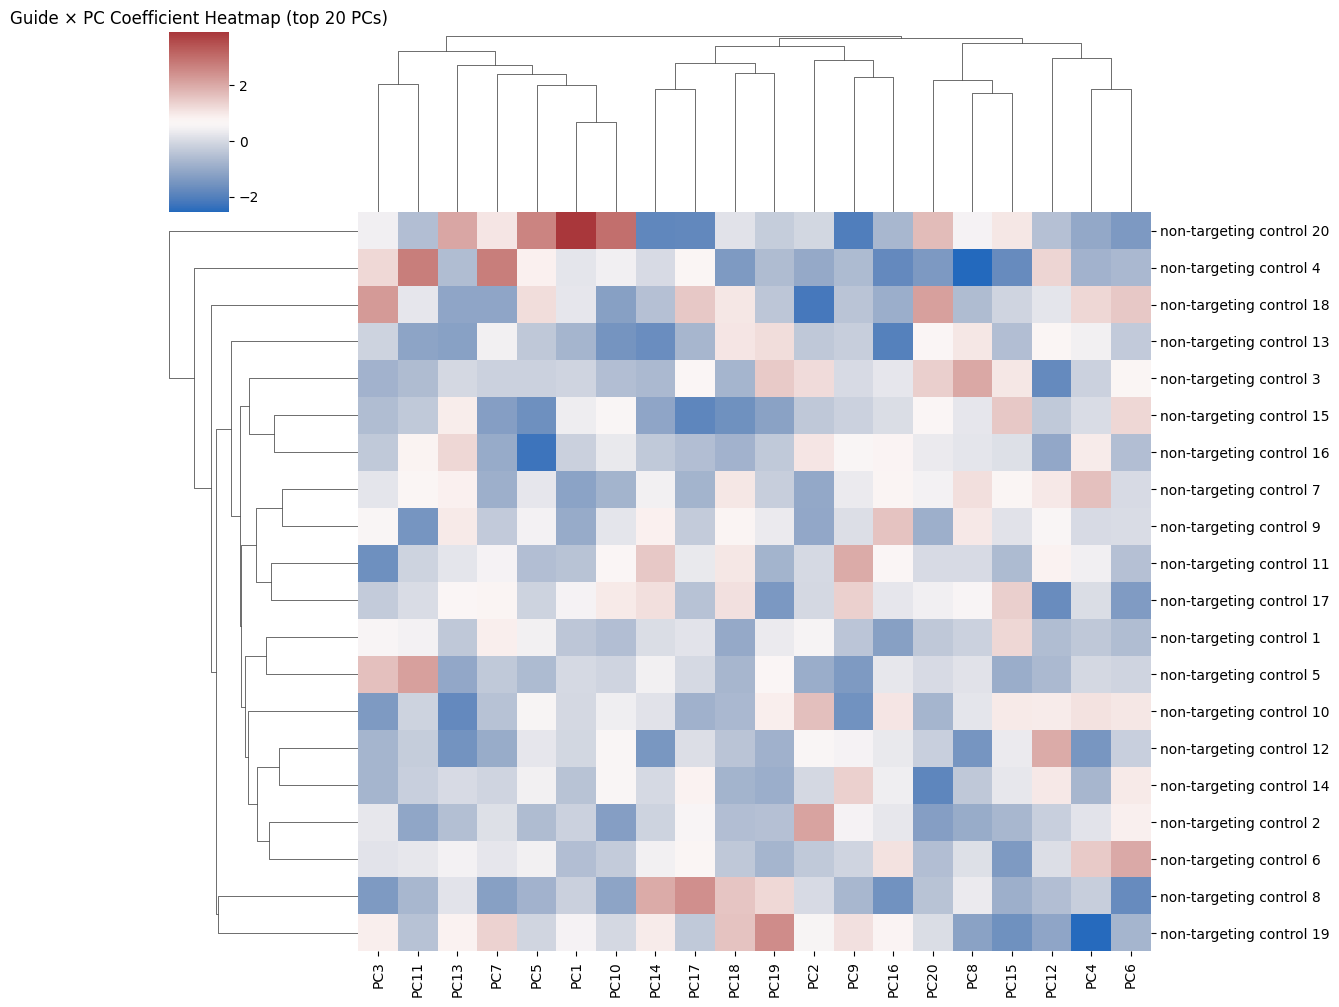

In [81]:
import seaborn as sns

# Optionally standardize for heatmap
from sklearn.preprocessing import StandardScaler
scaled = StandardScaler().fit_transform(coeff_matrix)

# Select top 20 PCs (columns)
sns.clustermap(pd.DataFrame(scaled[:, :20], index=guide_names),
               cmap="vlag", metric="euclidean", figsize=(12, 10),
               xticklabels=[f"PC{i+1}" for i in range(20)],
                yticklabels=[f"non-targeting control {i+1}" for i in range(20)])

plt.title("Guide × PC Coefficient Heatmap (top 20 PCs)")
plt.show()


In [82]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

models = {
    "IsolationForest": IsolationForest(random_state=0, contamination=0.1),
    "EllipticEnvelope": EllipticEnvelope(contamination=0.1),
    "LocalOutlierFactor": LocalOutlierFactor(),
    "OneClassSVM": OneClassSVM( nu=0.01)
}
c=0
outlier_scores = {}
#subset coeff_matrix array to be only first 20 
for name, model in models.items():
    print(f"Running model: {name}")
    
    if name == "LocalOutlierFactor":
        pred = model.fit_predict(coeff_matrix)
    else:
        model.fit(coeff_matrix)
        pred = model.predict(coeff_matrix)
    #add the votes with the name to the guide
    #if reaching 20 then break
    outlier_scores[name] = pd.Series(pred, index=guide_names, name=name)


Running model: IsolationForest
Running model: EllipticEnvelope
Running model: LocalOutlierFactor
Running model: OneClassSVM


In [83]:
outlier_counts_side = pd.DataFrame(outlier_scores).apply(lambda x: (x == -1).sum(), axis=0)

In [84]:
outlier_counts_side

IsolationForest        0
EllipticEnvelope       2
LocalOutlierFactor     0
OneClassSVM           20
dtype: int64

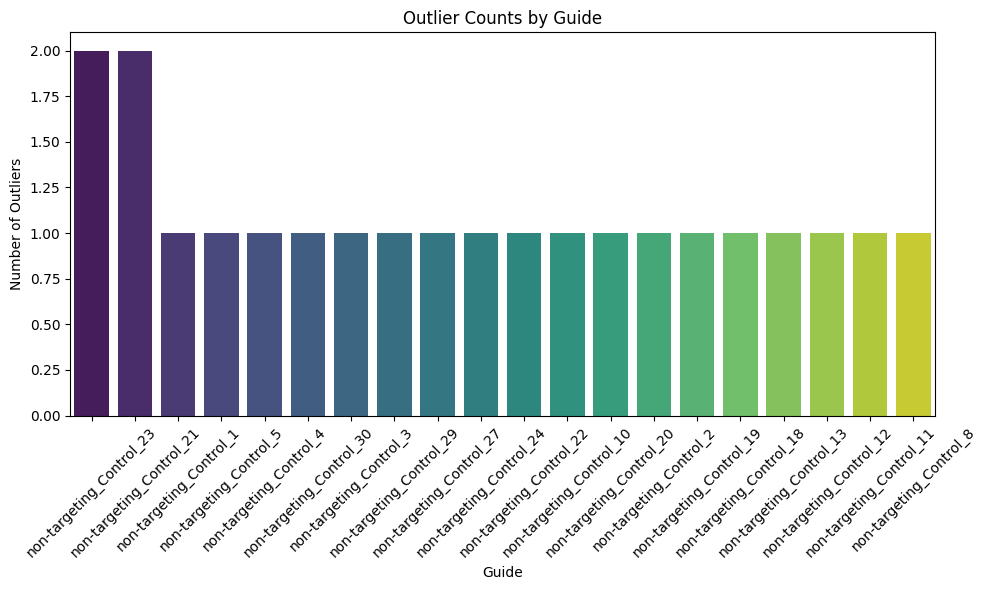

In [75]:
# sum the number of -1 per row in pd.DataFrame(outlier_scores) and make into barplit
#subset to only first 20 guides
outlier_counts = pd.DataFrame(outlier_scores).apply(lambda x: (x == -1).sum(), axis=1)
outlier_counts = outlier_counts.head(20)

outlier_counts = outlier_counts.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=outlier_counts.index, y=outlier_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Guide")
plt.ylabel("Number of Outliers")
plt.title("Outlier Counts by Guide")
plt.tight_layout()
plt.show()


In [76]:
#create a count plot of the number of outlier 
plt.figure(figsize=(10, 6))
county=pd.DataFrame(outlier_counts.value_counts()).reset_index()
county.head()

,index,count
0,1,18
1,2,2


<Figure size 1000x600 with 0 Axes>

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


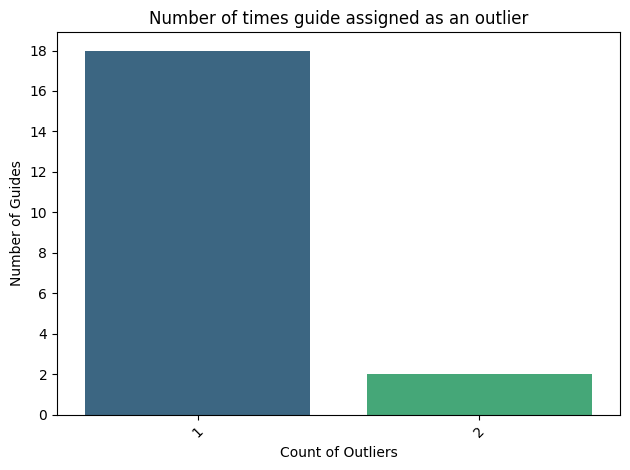

In [88]:

sns.barplot(county, x="index",y="count", palette="viridis")
#add line at y=3
plt.xticks(rotation=45)
plt.xlabel("Count of Outliers")
plt.ylabel("Number of Guides")
plt.title("Number of times guide assigned as an outlier")
#make y axis to lavel every two
plt.yticks(np.arange(0, county['count'].max()+1, 2))
#save as pdf
plt.tight_layout()
plt.savefig(loc+"figures/number_of_outliers_per_guide.pdf")

In [15]:

outlier_counts_df = outlier_counts_df.sort_values(by='Outlier Count', ascending=False)
#which guides is this make graph plit
outlier_counts_df.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Number of Outliers Detected by Each Model')
plt.xlabel('Model')
plt.ylabel('Outlier Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

NameError: name 'outlier_counts_df' is not defined

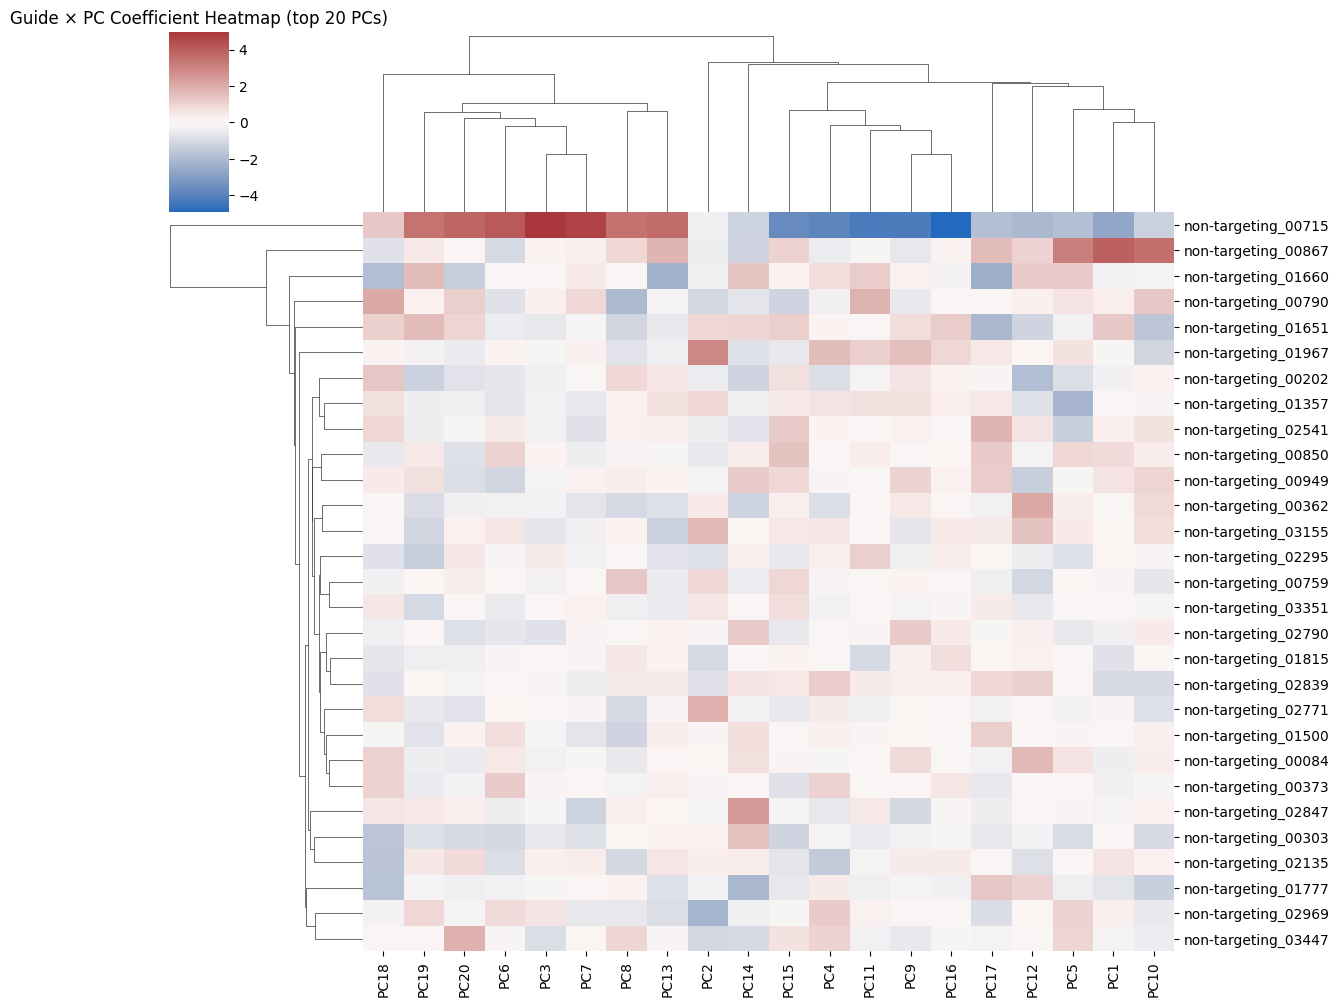

,IsolationForest,EllipticEnvelope,LocalOutlierFactor,OneClassSVM
non-targeting_00084,-1,1,-1,-1
non-targeting_00202,-1,1,-1,-1
non-targeting_00303,-1,1,-1,-1
non-targeting_00362,-1,1,1,-1
non-targeting_00373,-1,1,1,-1
non-targeting_00715,-1,-1,-1,-1
non-targeting_00759,-1,1,-1,-1
non-targeting_00790,-1,1,-1,-1
non-targeting_00850,-1,1,-1,-1
non-targeting_00867,-1,1,-1,-1
